# Identifying Invasive Ductal Carcinoma Pt. 2D
#### Using sci-kit learn and keras (tensorflow backend) to build CNNs to identify IDC in images

### Note: All neural networks included can be improved by extending the number of epochs. The number of epochs included was limited to 10 for computation speed and proof of concept. 

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt

from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Import Images and Process Them

In [2]:
benign = np.load('Desktop/ML/benign_rgb.npy')
malignant = np.load('Desktop/ML/malignant_rgb.npy')

In [3]:
print(len(benign))
print(len(malignant))

196454
78768


### Data Splitting

In [4]:
benign = random.sample(list(benign), 10000)
malignant = random.sample(list(malignant), 10000)

In [5]:
X = np.concatenate((benign, malignant))
Y1 = np.zeros((len(benign), ), dtype=int)
Y2 = np.ones((len(malignant), ), dtype=int)
Y = np.concatenate((Y1, Y2))

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print('Done!')

Done!


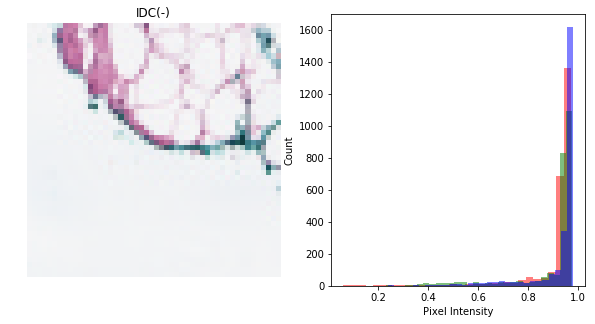

In [20]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1, 2, 2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:, :, 0].flatten(), bins=n_bins, lw=0, color='r', alpha=0.5)
    plt.hist(a[:, :, 1].flatten(), bins=n_bins, lw=0, color='g', alpha=0.5)
    plt.hist(a[:, :, 2].flatten(), bins=n_bins, lw=0, color='b', alpha=0.5)


plotHistogram(X[100])

In [8]:
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (16000, 50, 50, 3)
Testing Data Shape: (4000, 50, 50, 3)


In [9]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes=2)
Y_testHot = to_categorical(Y_test, num_classes=2)

In [10]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_train), Y_train)
print(class_weight)

[1.00439422 0.99564406]


In [11]:
# Helper Functions  Learning Curves and Confusion Matrix


class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""

    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plotKerasLearningCurve():
    plt.figure(figsize=(10, 5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc']  # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x: np.any([kk in x for kk in filt]),
                    metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(
            l,
            c='r' if 'val' not in k else 'b',
            label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(
            x, y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(
            x,
            y,
            '{} = {:.4f}'.format(x, y),
            size='15',
            color='r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None])
    plt.grid()
    plt.xlabel('Number of epochs')


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def runKerasCNNAugment(epoch, a, b, c, d):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = epoch
    #     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows, img_cols = 50, 50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(
        Conv2D(
            32, kernel_size=(3, 3), activation='relu',
            input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=
        False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=
        10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=
        0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=
        0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    model.fit_generator(
        datagen.flow(a, b, batch_size=32),
        steps_per_epoch=len(a) / 32,
        epochs=epochs,
        class_weight=class_weight,
        validation_data=[c, d],
        callbacks=[MetricsCheckpoint('logs')])
    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print(
        '\n',
        sklearn.metrics.classification_report(
            np.where(d > 0)[1],
            np.argmax(y_pred, axis=1),
            target_names=list(map_characters.values())),
        sep='')
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(d, axis=1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plot_confusion_matrix(
        confusion_mtx,
        classes=list(map_characters.values()),
        title='Confusion Matrix (Value Counts)')
    plot_confusion_matrix(
        confusion_mtx,
        classes=list(map_characters.values()),
        normalize=True,
        title='Confusion Matrix (Proportions)')

Epoch 1/10
500/500 [==============================] - 125s 249ms/step - loss: 0.5852 - acc: 0.7111 - val_loss: 0.4541 - val_acc: 0.8083
Epoch 2/10
500/500 [==============================] - 113s 225ms/step - loss: 0.4960 - acc: 0.7820 - val_loss: 0.4319 - val_acc: 0.8113
Epoch 3/10
500/500 [==============================] - 108s 216ms/step - loss: 0.4774 - acc: 0.7902 - val_loss: 0.4107 - val_acc: 0.8157
Epoch 4/10
500/500 [==============================] - 108s 215ms/step - loss: 0.4579 - acc: 0.7979 - val_loss: 0.4217 - val_acc: 0.8057
Epoch 5/10
500/500 [==============================] - 107s 215ms/step - loss: 0.4489 - acc: 0.8006 - val_loss: 0.4298 - val_acc: 0.8205
Epoch 6/10
500/500 [==============================] - 109s 218ms/step - loss: 0.4403 - acc: 0.8068 - val_loss: 0.3973 - val_acc: 0.8267
Epoch 7/10
500/500 [==============================] - 109s 218ms/step - loss: 0.4342 - acc: 0.8103 - val_loss: 0.4081 - val_acc: 0.8240
Epoch 8/10
500/500 [============================

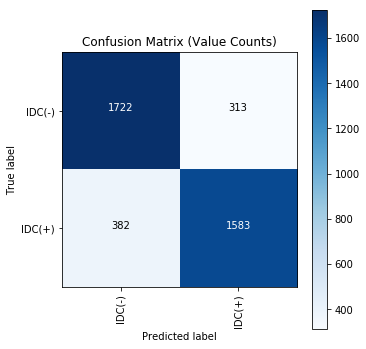

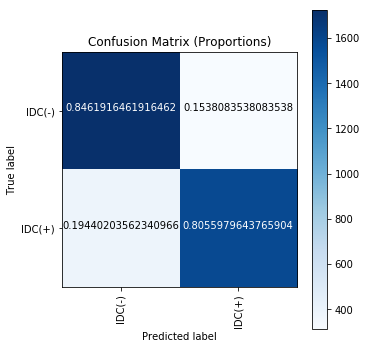

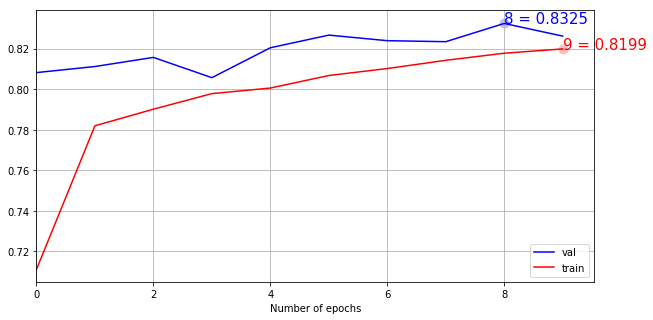

In [13]:
runKerasCNNAugment(10, X_train, Y_trainHot, X_test, Y_testHot)
plotKerasLearningCurve()

In [14]:
def runKerasCNNAugment_3conv(epoch, a, b, c, d):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = epoch
    #     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows, img_cols = 50, 50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(
        Conv2D(
            32, kernel_size=(3, 3), activation='relu',
            input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=
        False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=
        10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=
        0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=
        0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    model.fit_generator(
        datagen.flow(a, b, batch_size=32),
        steps_per_epoch=len(a) / 32,
        epochs=epochs,
        class_weight=class_weight,
        validation_data=[c, d],
        callbacks=[MetricsCheckpoint('logs')])
    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print(
        '\n',
        sklearn.metrics.classification_report(
            np.where(d > 0)[1],
            np.argmax(y_pred, axis=1),
            target_names=list(map_characters.values())),
        sep='')
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(d, axis=1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plot_confusion_matrix(
        confusion_mtx,
        classes=list(map_characters.values()),
        title='Confusion Matrix (Value Counts)')
    plot_confusion_matrix(
        confusion_mtx,
        classes=list(map_characters.values()),
        normalize=True,
        title='Confusion Matrix (Proportions)')

Epoch 1/10
500/500 [==============================] - 241s 483ms/step - loss: 0.5949 - acc: 0.6863 - val_loss: 0.5335 - val_acc: 0.7282
Epoch 2/10
500/500 [==============================] - 219s 439ms/step - loss: 0.5018 - acc: 0.7733 - val_loss: 0.4223 - val_acc: 0.8153
Epoch 3/10
500/500 [==============================] - 237s 473ms/step - loss: 0.4669 - acc: 0.7933 - val_loss: 0.4155 - val_acc: 0.8137
Epoch 4/10
500/500 [==============================] - 225s 450ms/step - loss: 0.4569 - acc: 0.7986 - val_loss: 0.4007 - val_acc: 0.8213
Epoch 5/10
500/500 [==============================] - 224s 447ms/step - loss: 0.4395 - acc: 0.8078 - val_loss: 0.3970 - val_acc: 0.8225
Epoch 6/10
500/500 [==============================] - 239s 478ms/step - loss: 0.4293 - acc: 0.8113 - val_loss: 0.4080 - val_acc: 0.8213
Epoch 7/10
500/500 [==============================] - 239s 478ms/step - loss: 0.4194 - acc: 0.8163 - val_loss: 0.4113 - val_acc: 0.8140
Epoch 8/10
500/500 [============================

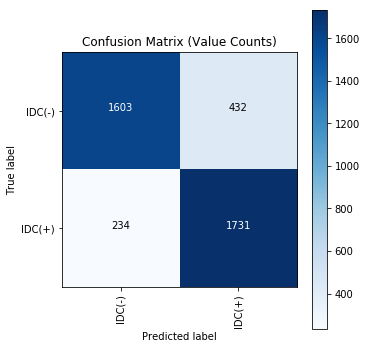

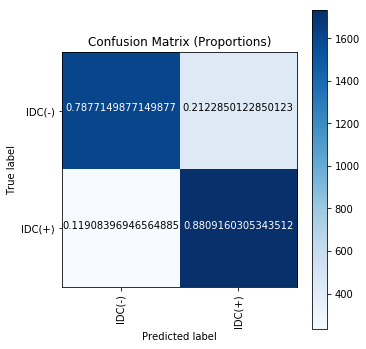

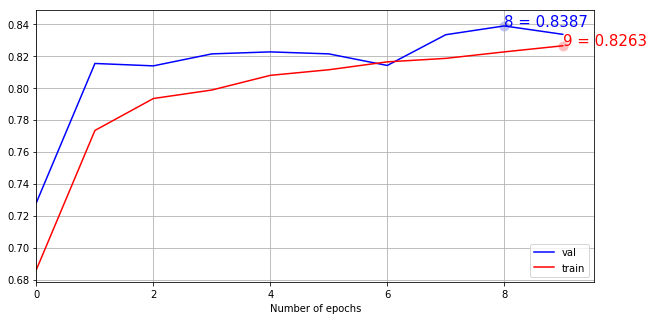

In [15]:
runKerasCNNAugment_3conv(10, X_train, Y_trainHot, X_test, Y_testHot)
plotKerasLearningCurve()

In [16]:
def runKerasCNNAugment_2layers(epoch, a, b, c, d):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = epoch
    #     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows, img_cols = 50, 50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(
        Conv2D(
            32, kernel_size=(3, 3), activation='relu',
            input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=
        False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=
        10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=
        0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=
        0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    model.fit_generator(
        datagen.flow(a, b, batch_size=32),
        steps_per_epoch=len(a) / 32,
        epochs=epochs,
        class_weight=class_weight,
        validation_data=[c, d],
        callbacks=[MetricsCheckpoint('logs')])
    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print(
        '\n',
        sklearn.metrics.classification_report(
            np.where(d > 0)[1],
            np.argmax(y_pred, axis=1),
            target_names=list(map_characters.values())),
        sep='')
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(d, axis=1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plot_confusion_matrix(
        confusion_mtx,
        classes=list(map_characters.values()),
        title='Confusion Matrix (Value Counts)')
    plot_confusion_matrix(
        confusion_mtx,
        classes=list(map_characters.values()),
        normalize=True,
        title='Confusion Matrix (Proportions)')

Epoch 1/10
500/500 [==============================] - 254s 509ms/step - loss: 0.6603 - acc: 0.6022 - val_loss: 0.5171 - val_acc: 0.7630
Epoch 2/10
500/500 [==============================] - 280s 560ms/step - loss: 0.5357 - acc: 0.7493 - val_loss: 0.4369 - val_acc: 0.8093
Epoch 3/10
500/500 [==============================] - 233s 467ms/step - loss: 0.4856 - acc: 0.7840 - val_loss: 0.4563 - val_acc: 0.7917
Epoch 4/10
500/500 [==============================] - 239s 478ms/step - loss: 0.4635 - acc: 0.7950 - val_loss: 0.4621 - val_acc: 0.8035
Epoch 5/10
500/500 [==============================] - 253s 507ms/step - loss: 0.4477 - acc: 0.8035 - val_loss: 0.4206 - val_acc: 0.8153
Epoch 6/10
500/500 [==============================] - 256s 512ms/step - loss: 0.4327 - acc: 0.8093 - val_loss: 0.4940 - val_acc: 0.7802
Epoch 7/10
500/500 [==============================] - 253s 506ms/step - loss: 0.4200 - acc: 0.8161 - val_loss: 0.3829 - val_acc: 0.8325
Epoch 8/10
500/500 [============================

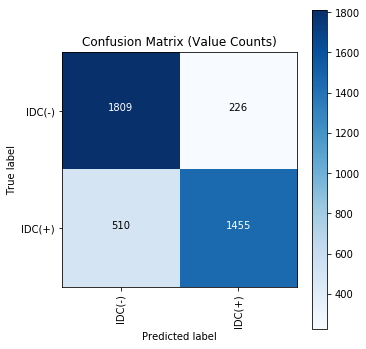

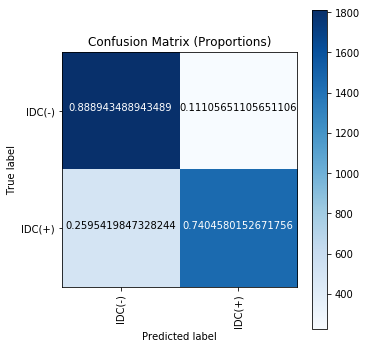

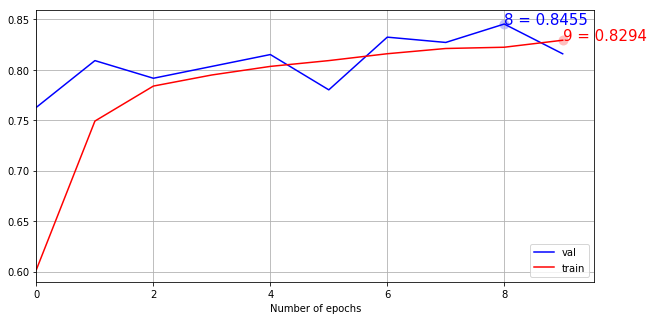

In [17]:
runKerasCNNAugment_2layers(10, X_train, Y_trainHot, X_test, Y_testHot)
plotKerasLearningCurve()

In [18]:
def sample_model(epoch, a, b, c, d):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = epoch
    #     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows, img_cols = 50, 50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(
        Conv2D(
            32, kernel_size=(3, 3), activation='relu',
            input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=
        False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=True,  # apply ZCA whitening
        rotation_range=
        20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=
        0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=
        0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    model.fit_generator(
        datagen.flow(a, b, batch_size=32),
        steps_per_epoch=len(a) / 32,
        epochs=epochs,
        class_weight=class_weight,
        validation_data=[c, d],
        callbacks=[MetricsCheckpoint('logs')])
    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print(
        '\n',
        sklearn.metrics.classification_report(
            np.where(d > 0)[1],
            np.argmax(y_pred, axis=1),
            target_names=list(map_characters.values())),
        sep='')
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(d, axis=1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plot_confusion_matrix(
        confusion_mtx,
        classes=list(map_characters.values()),
        title='Confusion Matrix (Value Counts)')
    plot_confusion_matrix(
        confusion_mtx,
        classes=list(map_characters.values()),
        normalize=True,
        title='Confusion Matrix (Proportions)')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras_preprocessing/image.py:787: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras_preprocessing/image.py:988: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras_preprocessing/image.py:1007: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


500/500 [==============================] - 128s 255ms/step - loss: 0.6094 - acc: 0.6805 - val_loss: 0.4805 - val_acc: 0.7980
Epoch 2/10
500/500 [==============================] - 128s 255ms/step - loss: 0.5005 - acc: 0.7756 - val_loss: 0.4195 - val_acc: 0.8185
Epoch 3/10
500/500 [==============================] - 133s 266ms/step - loss: 0.4707 - acc: 0.7906 - val_loss: 0.4297 - val_acc: 0.8047
Epoch 4/10
500/500 [==============================] - 126s 252ms/step - loss: 0.4573 - acc: 0.7981 - val_loss: 0.4023 - val_acc: 0.8237
Epoch 5/10
500/500 [==============================] - 130s 261ms/step - loss: 0.4458 - acc: 0.8046 - val_loss: 0.4417 - val_acc: 0.7943
Epoch 6/10
500/500 [==============================] - 130s 260ms/step - loss: 0.4381 - acc: 0.8048 - val_loss: 0.3836 - val_acc: 0.8277
Epoch 7/10
500/500 [==============================] - 127s 254ms/step - loss: 0.4350 - acc: 0.8087 - val_loss: 0.3988 - val_acc: 0.8283
Epoch 8/10
500/500 [==============================] - 134s 

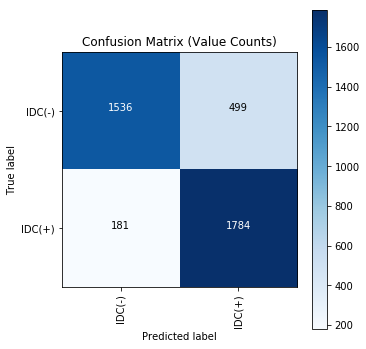

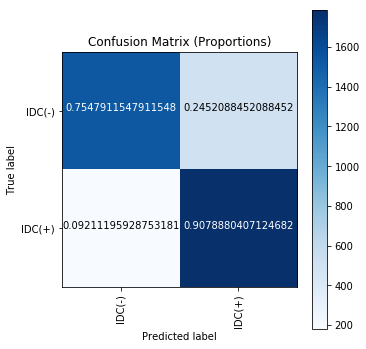

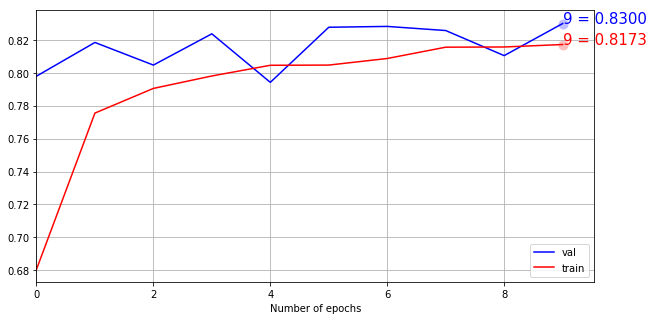

In [19]:
sample_model(10, X_train, Y_trainHot, X_test, Y_testHot)
plotKerasLearningCurve()